In [74]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import truncnorm

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, is_impute_missing_values=True, has_target=True):
        self.is_impute_missing_values = is_impute_missing_values
        self.has_target = has_target
        self.mean_numsold = None
        self.std_numsold = None

    def fit(self, X, y=None):
        if self.has_target:
            self.mean_numsold = X["num_sold"].mean()
            self.std_numsold = X["num_sold"].std()
        return self

    def impute_missing_values(self, X):
        if not self.has_target:
            return X  # Skip for test data
        n_missing_values = X["num_sold"].isna().sum()
        random_values = truncnorm.rvs(
            a=0, b=np.inf, loc=self.mean_numsold, scale=self.std_numsold, size=n_missing_values
        )
        X.loc[X["num_sold"].isna(), "num_sold"] = random_values
        return X

    def scale_num_sold(self, X):
        if not self.has_target:
            return X  # Skip for test data
        X["num_sold"] = (X["num_sold"] - self.mean_numsold) / self.std_numsold
        return X

    def transform(self, Y):
        X = Y.copy()
        X = self.compute_temporal_variables(X)
        X = self.compute_sin_cos(X)
        X.drop(columns=["id", "date"], inplace=True)
        X = self.compute_onehot_variables(X)
        if self.is_impute_missing_values and self.has_target:
            X = self.impute_missing_values(X)
        if self.has_target:
            X["num_sold"] = np.log1p(X["num_sold"])
            X = self.scale_num_sold(X)
        return X


In [70]:
FOLDER = "playground-series-s5e1/"
train_data = pd.read_csv(FOLDER + "train.csv")
transfomer = CustomTransformer(is_impute_missing_values=False, has_target=True).fit(train_data)
transformed_train_data = transfomer.fit_transform(train_data)


In [71]:
train_data.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold'], dtype='object')

In [75]:
transformer_imputed = CustomTransformer(is_impute_missing_values=True, has_target=True).fit(train_data)
transformed_train_data_imputed = transformer_imputed.fit_transform(train_data)

AttributeError: 'CustomTransformer' object has no attribute 'compute_temporal_variables'

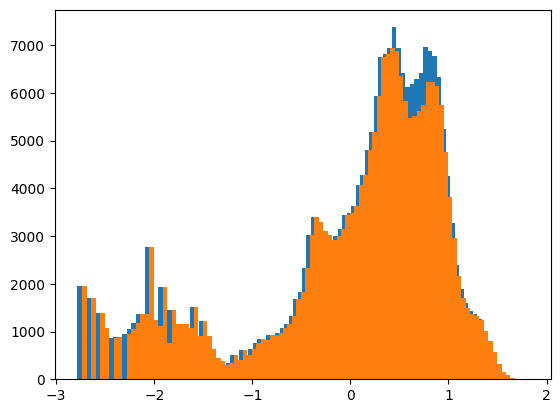

In [73]:
plt.hist(transformed_train_data_imputed["num_sold"],bins=100)
plt.hist(transformed_train_data["num_sold"],bins=100)
plt.show()

In [18]:
transformed_train_data.columns

Index(['num_sold', 'year', 'month', 'day', 'weekday', 'is_weekend', 'sin_day',
       'cos_day', 'sin_month', 'cos_month', 'sin_weekday', 'cos_weekday',
       'sin_year', 'cos_year', 'store_Discount Stickers',
       'store_Premium Sticker Mart', 'store_Stickers for Less',
       'product_Holographic Goose', 'product_Kaggle', 'product_Kaggle Tiers',
       'product_Kerneler', 'product_Kerneler Dark Mode', 'country_Canada',
       'country_Finland', 'country_Italy', 'country_Kenya', 'country_Norway',
       'country_Singapore', 'quarter_1', 'quarter_2', 'quarter_3', 'quarter_4',
       'weeks_0', 'weeks_1', 'weeks_2', 'weeks_3', 'weeks_4'],
      dtype='object')

In [ ]:
#Now we are ready to train a model 